In [1]:
from tool import *
import missingno as msno
pd.set_option('display.max_colwidth', None)

## 1. DOA DB를 불러옴

In [2]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.fillna('TBD').pivot_table(values='S/N', index=['Vendor', 'DOA Number', 'FOC Number', 'Grouping Number', 'HBL', 'OBD'], aggfunc='count').fillna(0).convert_dtypes()

S/N
Vendor   DOA Number      FOC Number  Grouping Number HBL            OBD            
Pegatron LG20230410      F1000208058 CPCZ2304110002  SEL-0056 0985  2023-04-15   14
         LG20230705      F1000210801 CGMZ2307050032  KR101133932    2023-07-08    3
         LG211006        F1000190536 CPCZ2110070006  SMCIA216103    2021-10-12   35
         LG211102        F1000191443 CPCZ2111030006  SMCIA216793    2021-11-09   26
         LG211201        F1000192504 CPCZ2112060001  SMCIA217762    2021-12-09   63
         LG220304        F1000195153 CPCZ2203070002  SEL-0052 9817  2022-03-17   51
         LG220510        F1000197493 CPCZ2205180002  SEL-0053 5903  2022-05-25   27
         LG220721        F1000199890 CPCZ2207290002  SEL-0054 0419  2022-08-01   39
         LG220818        F1000200869 CPCZ2209010002  988-40865871   2022-09-01  562
         LG221017        F1000202530 CPCZ2210200001  SEL-0054 5900  2022-10-23   42
         LG221108        F1000203191 CPCZ2211090008  5501 1591 8253 2022-11-13   45
         LG230308        F1000207121 CPCZ2303140001  SEL-0055 9015  2023-03-18   10
Quanta   N5T21916H-391   F1000190204 CPCZ2109280001  SMCIA215936    2021-10-07    8
         N5V21927H-391   F1000190524 CPCZ2110070001  SMCIA216102    2021-10-12  312
         N5V21B08H-391   F1000191764 CPCZ2111150001  SMCIA217109    2021-11-18  137
         N5V21B24H-391L  F1000192308 CPCZ2111290001  SMCIA217546    2021-12-02   47
         N5V21C16H-391L  F1000192987 CPCZ2112210001  SMCIA218236    2021-12-23  121
         N5V22112H-391L  F1000193650 CPCZ2201180003  SMCIA220491    2022-01-20  217
         N5V22316H-391L  F1000195776 CPCZ2203240001  SEL-0053 2825  2022-04-14  261
         N5V22513H-391L  F1000197491 CPCZ2205180001  SEL-0053 4511  2022-05-25  373
         N5V22613H-391L  F1000198527 CPCZ2206200002  SEL-0053 8703  2022-07-03   79
         N5V22719H-391L  F1000199889 CPCZ2207290001  SEL-0054 0418  2022-08-01  119
         N5V22720H-391L  F1000200529 CPCZ2208240001  112-64178870   2022-08-26  323
         N5V22721H-391L  F1000200529 CPCZ2208240001  112-64178870   2022-08-26  143
         N5V22A08H-391L  F1000202340 CPCZ2210170001  SEL-0054 5657  2022-10-20  119
         N5V22B10H-391L  F1000203479 CPCZ2211160006  550115928366   2022-11-20   37
         N5V22C08H-391L  F1000204203 CPCZ2212090001  SEL-0055 2553  2022-12-14   78
         N5V230310H-391L F1000207964 CPCZ2304060005  SEL-0056 0746  2023-04-11  136
         N5V23424H-391L  F1000208471 CPCZ2304260003  KR101132413    2023-05-06   10
         N5V23522H-391L  F1000209363 CPCZ2305240003  KR101132984    2023-05-30   25
         N5V23625H-391L  F1000210782 CPCZ2307050003  KR101133931    2023-07-08   67

<Axes: >

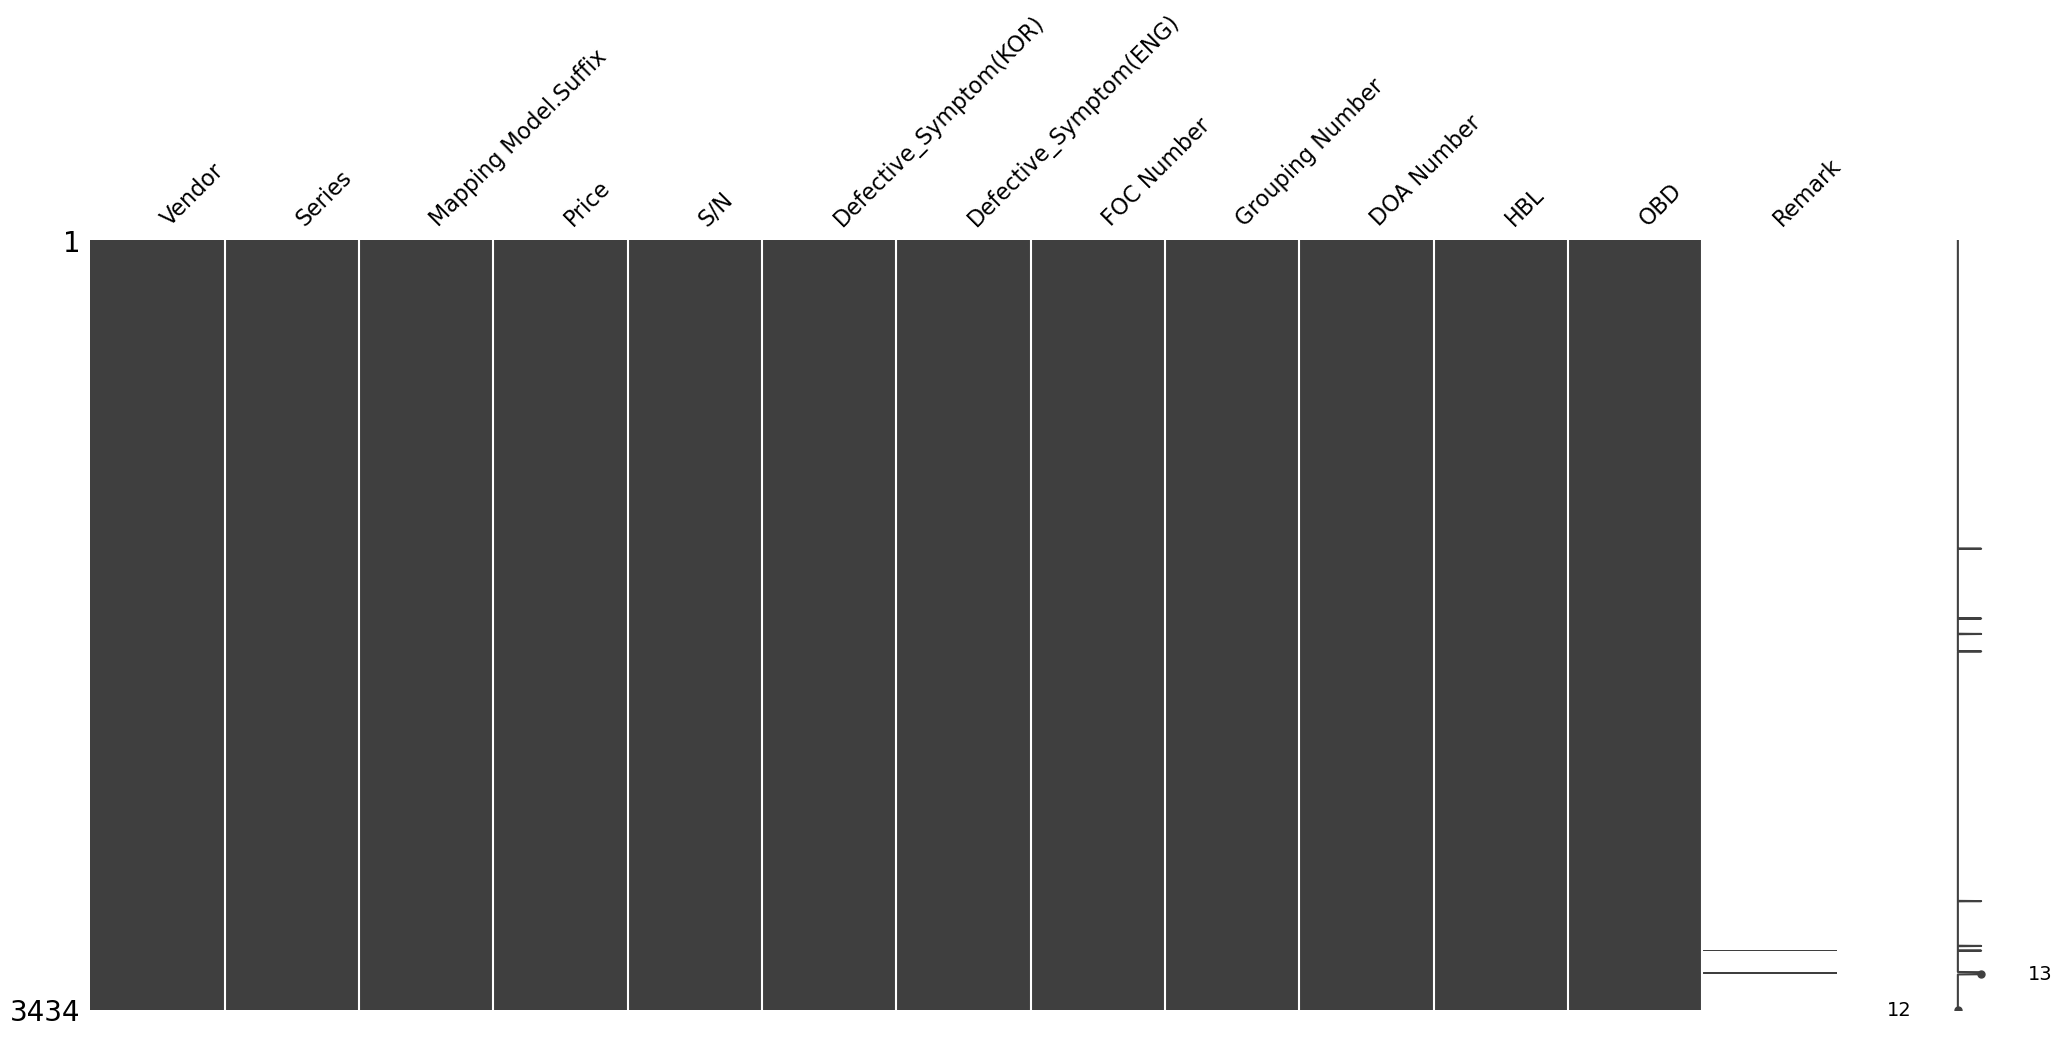

In [6]:
msno.matrix(df) # 컬럼별 결측치가 어느 정도 있는지 확인

## 2. 신규 DOA 파일을 가져와서 불량내용을 영문 번역

In [5]:
# 권혁호 주임 불량 현황 엑셀파일 불러옴
df_new = pd.read_excel(get_filename(), sheet_name=0)
df_new = df_new[['분류', '모델', 'S/N', '비고']]
df_new.columns  = ['Vendor', 'Mapping Model.Suffix', 'S/N', 'Defective_Symptom(KOR)']
df_new = df_new.dropna(how='all')
df_new['Mapping Model.Suffix'] = df_new['Mapping Model.Suffix'].str.strip() # 모델명 공백 정리
df_new['S/N'] = df_new['S/N'].str.strip() # S/N 공백 정리
# df_new = df_new[~(df_new['Vendor'] == '남경')]
df_new['Defective_Symptom(KOR)'] = df_new['Defective_Symptom(KOR)'].str.strip() # 불량명 공백 정리
df_new['Defective_Symptom(KOR)'] = df_new['Defective_Symptom(KOR)'].str.replace('\n', ',') # 개행문자(\n) 을 쉼표(,) 로 대체
df_new.groupby('Vendor')['S/N'].count() # 물류에서 관리하는 파일 기준, 업체별 불량 수량 확인

Vendor
Quanta    68
남경        95
Name: S/N, dtype: int64

In [6]:
# 모델과 Vendor과 잘 mapping 되었는지 2차 확인용
df_new['Mapping Model.Suffix'] = df_new['Mapping Model.Suffix'].str.strip()
df_new['S/N'] = df_new['S/N'].str.strip()
df_new.insert(1, 'Series', df_new['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model))
df_new['Vendor_check'] = df_new['Series'].replace(vendor_find)
df_new[~(df_new['Vendor_check'].isin(['Quanta', 'Pegatron']))]['Series'].unique() # Series 모델명 기준으로 Vendor 명이 Quanta, Pegatron 이 아닌 것의 Series 모델명에 ODM 모델명이 없는지 확인

array(['14Z90R', '14ZD90R', '15Z90R', '15Z90RT', '15ZB90Q', '15ZB90R',
       '15ZD90R', '15ZD90RT', '15ZD90RU', '16MR70.ASDK', '16UD70R',
       '16Z90Q', '16Z90R', '16Z90RS', '16ZD90R', '16ZD90RS', '16ZD90RU',
       '17ZG90Q', '24V70Q', '27V70Q'], dtype=object)

In [7]:
df_new = df_new[(df_new['Vendor_check'].isin(['Quanta', 'Pegatron']))]
df_new

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor_check
0,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,D-Part 누름시 소음,Quanta
1,Quanta,14T90R,14T90R-G.AA50K,96462301QCJZ566396,"스피커&마이크 무감, Pen Sheet 구겨짐",Quanta
2,Quanta,14T90R,14TD90R-G.AX56K,96484303QCJZ571332,Box 불량,Quanta
3,Quanta,14T90R,14TD90R-G.AX56K,96484303QCJZ571428,Box 불량,Quanta
4,Quanta,14T90R,14TD90R-G.AX56K,96484303QCKJ571325,Box 불량,Quanta
...,...,...,...,...,...,...
63,Quanta,16T90R,16T90R-G.AA50K,96491305QCDG560178,LCD Open/Close Noise,Quanta
64,Quanta,16T90R,16T90R-G.AA50K,96491305QCVU560191,C-Part 수축,Quanta
65,Quanta,16T90R,16T90R-G.AA50K,96491305QCYQ560170,"LCD 얼룩, D-Part Screw Deco 누락",Quanta
66,Quanta,16T90R,16T90R-G.AA70K,96452306QCMR557835,D-Part Dent,Quanta


In [8]:
df_new[~(df_new['Vendor'] == df_new['Vendor_check'])] # Vendor check 결과와 비교해 Vendor명이 잘못 반영된 것이 없는지 확인

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor_check


In [10]:
# 만약 잘못 반영된 것이 있다면 해당 건의 Vendor 명을 수정함
df_new.loc[~(df_new['Vendor'] == df_new['Vendor_check']), 'Vendor'] = 'Quanta'

In [9]:
df_new = df_new.drop('Vendor_check', axis=1)
df_new.head(1)

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR)
0,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,D-Part 누름시 소음


In [10]:
df_new['Vendor'].value_counts()

Quanta    68
Name: Vendor, dtype: int64

In [11]:
df_new[~df_new['S/N'].str.contains(odm_sn)] # S/N이 PC odm모델의 S/N 표현으로 되어 있지 않은 것 확인

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR)


In [12]:
df_new.shape

(68, 5)

In [13]:
c1 = df_new['Vendor'].isin(['Pegatron', 'Quanta'])
df_new = df_new[c1]
df_new.shape

(68, 5)

In [14]:
df_new.groupby('Vendor')['Mapping Model.Suffix'].count()

Vendor
Quanta    68
Name: Mapping Model.Suffix, dtype: int64

In [15]:
with open('D:/Data/Quanta Korea Repair list.bin', 'rb') as f:
    df = pickle.load(f)
df.head(3)

,Vendor,Series,Mapping Model.Suffix,S/N,Quanta PN,Defective_Symptom(KOR),Defective_Symptom(ENG),Repair Item1,Repair Material P/N1,Repair Item2,Repair Material P/N2,Repair Item3,Repair Material P/N3,Remark
0,Quanta,14T90Q,14T90Q-G.AA56K,206QCXM562850,1NLJ0000025,Box 불량,Box damage,Box,3TNLJBA0000,Box label,NaN,NaN,NaN,NaN
1,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
2,Quanta,14T90R,14T90R-G.AA50K,96462301QCJZ566396,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN


In [16]:
df.shape # 수리대상 리스트의 개수 확인

(217, 14)

In [17]:
# 수리 모델 리스트 중에서 물류 불량 리스트에 없는 것이 있는지 확인(수리해야 할 set 로 되어 있는데 현재 불량리스트에 없는 것임, 즉, 수리할 필요 없는 것일 수 있음)
df[~(df['S/N'].isin(df_new['S/N']))]

,Vendor,Series,Mapping Model.Suffix,S/N,Quanta PN,Defective_Symptom(KOR),Defective_Symptom(ENG),Repair Item1,Repair Material P/N1,Repair Item2,Repair Material P/N2,Repair Item3,Repair Material P/N3,Remark
0,Quanta,14T90Q,14T90Q-G.AA56K,206QCXM562850,1NLJ0000025,Box 불량,Box damage,Box,3TNLJBA0000,Box label,NaN,NaN,NaN,NaN
3,Quanta,14T90R,14T90R-G.AA50K,96462301QCMR566411,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
4,Quanta,14T90R,14T90R-G.AA50K,96462301QCRN566422,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
5,Quanta,14T90R,14T90R-G.AA50K,96462301QCWC566417,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
6,Quanta,14T90P,14TD90P-G.AX7GK,201QCUK579054,1NLH0000322,Box 불량,Box damage,Box,3TNLHBA0000,Box label,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCMR561411,NaN,BOX 불량,BOX bad,Box,HFLGH003010,Box label,NaN,NaN,NaN,NaN
213,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCNL561559,NaN,BOX 불량,BOX bad,Box,HFLGH003010,Box label,NaN,NaN,NaN,NaN
214,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCQX561908,NaN,BOX 불량,BOX bad,Box,HFLGH003010,Box label,NaN,NaN,NaN,NaN
215,Quanta,16T90R,16T90R-G.AA50K,96491305QCGW560199,NaN,박스불량,bad box,Box,3TNLJBA0090,Box label,NaN,NaN,NaN,NaN


In [18]:
remove_list = df[~(df['S/N'].isin(df_new['S/N']))]['S/N'].tolist() # 상기 수리할 필요 없는 S/N을 리스트로 만듬

In [19]:
df.shape

(217, 14)

In [23]:
df = df[~df['S/N'].isin(remove_list)] # 제거할 S/N을 제외하고 수리할 DB를 다시 만듬

In [24]:
df.shape

(192, 14)

In [25]:
with open('D:/Data/Quanta Korea Repair list.bin', 'wb') as f: # 변경된 수리 대상 DB를 저장
    pickle.dump(df, f)

In [20]:
df_new[~(df_new['S/N'].isin(df['S/N']))] # 물류 불량 리스트 중에서 수리 대상으로 파악되어 있는 리스트의 S/N을 제외한 것, 즉 새롭게 DOA로 보내야 할 set만 Sorting해봄

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR)
11,Quanta,14T90R,14TD90R-G.AX56K,96484305QCLH560128,Box 불량
12,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCBD560509,BOX 불량
13,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCCV560635,BOX 불량
14,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCEA560572,BOX 불량
15,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCFT560147,BOX 불량
16,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCFT560219,BOX 불량
17,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCGW560159,BOX 불량
18,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCGW560183,BOX 불량
19,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCGW560255,BOX 불량
20,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCGW560327,BOX 불량


In [27]:
df_new[~(df_new['S/N'].isin(df['S/N']))].to_clipboard() # 위의 리스트를 copy해서 엑셀에서 DOA와 평택 수리 대상으로 구분 작업함

In [22]:
df_new = pd.read_clipboard()
df_new

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),구분
0,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,D-Part 누름시 소음,DOA
1,Quanta,14T90R,14T90R-G.AA50K,96462301QCJZ566396,"스피커&마이크 무감, Pen Sheet 구겨짐",DOA
2,Quanta,14T90R,14TD90R-G.AX56K,96484303QCJZ571332,Box 불량,NaN
3,Quanta,14T90R,14TD90R-G.AX56K,96484303QCJZ571428,Box 불량,NaN
4,Quanta,14T90R,14TD90R-G.AX56K,96484303QCKJ571325,Box 불량,NaN
...,...,...,...,...,...,...
63,Quanta,16T90R,16T90R-G.AA50K,96491305QCDG560178,LCD Open/Close Noise,DOA
64,Quanta,16T90R,16T90R-G.AA50K,96491305QCVU560191,C-Part 수축,DOA
65,Quanta,16T90R,16T90R-G.AA50K,96491305QCYQ560170,"LCD 얼룩, D-Part Screw Deco 누락",DOA
66,Quanta,16T90R,16T90R-G.AA70K,96452306QCMR557835,D-Part Dent,DOA


In [23]:
new_doa = df_new[df_new['구분'] == 'DOA']
new_doa

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),구분
0,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,D-Part 누름시 소음,DOA
1,Quanta,14T90R,14T90R-G.AA50K,96462301QCJZ566396,"스피커&마이크 무감, Pen Sheet 구겨짐",DOA
22,Quanta,15U40Q,15U40Q-G.AR5MK,63367306QCJZ560484,LCD 세로줄(간헐적),DOA
23,Quanta,15U40R,15U40R-G.AR30K,96473301QCVU561095,C-Part Label 위치 불량,DOA
24,Quanta,15U40R,15U40R-G.AR56K,96497305QCLH563104,LCD Open/Close Noise,DOA
28,Quanta,15U40R,15U40R-G.ARTWK,97487303QCJZ570684,LCD Open/Close Noise,DOA
29,Quanta,15U50Q,15U50Q-G.AP50ML,84586303QCLH566904,LCD 세로줄,DOA
31,Quanta,15U50Q,15U50Q-G.AR3DK,95454301QCAS569848,Space Bar 우측 이상소음,DOA
32,Quanta,15U50Q,15U50Q-G.AR50K,72628204QCRN561542,LCD 백점,DOA
33,Quanta,15U50Q,15U50Q-G.AS50ML,84585305QCDG563178,System 이상소음,DOA


In [24]:
new_doa['Defective_Symptom(ENG)'] = new_doa['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_4000\443106964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_doa['Defective_Symptom(ENG)'] = new_doa['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])


In [26]:
new_doa[['Defective_Symptom(KOR)', 'Defective_Symptom(ENG)']].iloc[:] # 번역잘 되었는지 확인

,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,D-Part 누름시 소음,Noise when pressing D-Part
1,"스피커&마이크 무감, Pen Sheet 구겨짐","Insensitive speaker &amp; microphone, wrinkled pen sheet"
22,LCD 세로줄(간헐적),LCD vertical lines (intermittent)
23,C-Part Label 위치 불량,Poor positioning of C-Part Label
24,LCD Open/Close Noise,LCD Open/Close Noise
28,LCD Open/Close Noise,LCD Open/Close Noise
29,LCD 세로줄,LCD Vertical Line
31,Space Bar 우측 이상소음,Abnormal noise on the right side of the Space Bar
32,LCD 백점,LCD white point
33,System 이상소음,System abnormal noise


### ODM 업체로 보낼 파일 생성

In [27]:
today = datetime.date.today()
vendor = 'Quanta'
new_doa.reset_index(drop=True).to_excel(f'D:/Python result/{today.isoformat()}_{vendor}_DOA_{new_doa.shape[0]}pcs.xlsx')

## 수리할 Set는 수리대상 DB에 추가함

In [29]:
add_repair = df_new[df_new['구분'].isnull()]
add_repair

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),구분
2,Quanta,14T90R,14TD90R-G.AX56K,96484303QCJZ571332,Box 불량,NaN
3,Quanta,14T90R,14TD90R-G.AX56K,96484303QCJZ571428,Box 불량,NaN
4,Quanta,14T90R,14TD90R-G.AX56K,96484303QCKJ571325,Box 불량,NaN
5,Quanta,14T90R,14TD90R-G.AX56K,96484303QCLH571464,Box 불량,NaN
6,Quanta,14T90R,14TD90R-G.AX56K,96484303QCNL568903,Box 불량,NaN
7,Quanta,14T90R,14TD90R-G.AX56K,96484303QCRN571526,Box 불량,NaN
8,Quanta,14T90R,14TD90R-G.AX56K,96484303QCSF571390,Box 불량,NaN
9,Quanta,14T90R,14TD90R-G.AX56K,96484303QCTB571393,Box 불량,NaN
10,Quanta,14T90R,14TD90R-G.AX56K,96484303QCUK571350,Box 불량,NaN
11,Quanta,14T90R,14TD90R-G.AX56K,96484305QCLH560128,Box 불량,NaN


In [30]:
add_repair['Defective_Symptom(ENG)'] = add_repair['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_4000\2310646373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_repair['Defective_Symptom(ENG)'] = add_repair['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])


In [31]:
add_repair[['Defective_Symptom(KOR)', 'Defective_Symptom(ENG)']].iloc[:] # 번역잘 되었는지 확인

,Defective_Symptom(KOR),Defective_Symptom(ENG)
2,Box 불량,Box bad
3,Box 불량,Box bad
4,Box 불량,Box bad
5,Box 불량,Box bad
6,Box 불량,Box bad
7,Box 불량,Box bad
8,Box 불량,Box bad
9,Box 불량,Box bad
10,Box 불량,Box bad
11,Box 불량,Box bad


In [33]:
add_repair.to_clipboard()

In [49]:
df.shape

(192, 14)

In [51]:
df = pd.concat([df, add_repair.drop('구분', axis=1)]).reset_index(drop=True)
df

,Vendor,Series,Mapping Model.Suffix,S/N,Quanta PN,Defective_Symptom(KOR),Defective_Symptom(ENG),Repair Item1,Repair Material P/N1,Repair Item2,Repair Material P/N2,Repair Item3,Repair Material P/N3,Remark
0,Quanta,14T90Q,14T90Q-G.AA56K,206QCXM562850,1NLJ0000025,Box 불량,Box damage,Box,3TNLJBA0000,Box label,NaN,NaN,NaN,Box needs to be replaced
1,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,Box needs to be replaced
2,Quanta,14T90R,14T90R-G.AA50K,96462301QCJZ566396,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,Box needs to be replaced
3,Quanta,14T90R,14T90R-G.AA50K,96462301QCMR566411,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,Box needs to be replaced
4,Quanta,14T90R,14T90R-G.AA50K,96462301QCRN566422,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,Box needs to be replaced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCMR561411,NaN,BOX 불량,BOX bad,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCNL561559,NaN,BOX 불량,BOX bad,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCQX561908,NaN,BOX 불량,BOX bad,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,Quanta,16T90R,16T90R-G.AA50K,96491305QCGW560199,NaN,박스불량,bad box,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df.shape

(217, 14)

In [13]:
df = pd.read_clipboard()
df

,Vendor,Series,Mapping Model.Suffix,S/N,Quanta PN,Defective_Symptom(KOR),Defective_Symptom(ENG),Repair Item1,Repair Material P/N1,Repair Item2,Repair Material P/N2,Repair Item3,Repair Material P/N3,Remark
0,Quanta,14T90Q,14T90Q-G.AA56K,206QCXM562850,1NLJ0000025,Box 불량,Box damage,Box,3TNLJBA0000,Box label,NaN,NaN,NaN,NaN
1,Quanta,14T90R,14T90R-G.AA50K,96462301QCDG566410,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
2,Quanta,14T90R,14T90R-G.AA50K,96462301QCJZ566396,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
3,Quanta,14T90R,14T90R-G.AA50K,96462301QCMR566411,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
4,Quanta,14T90R,14T90R-G.AA50K,96462301QCRN566422,1NLJB000023,Box 불량,Box damage,Box,3TNLJBA0080,Box label,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCMR561411,NaN,BOX 불량,BOX bad,Box,HFLGH003010,Box label,NaN,NaN,NaN,NaN
213,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCNL561559,NaN,BOX 불량,BOX bad,Box,HFLGH003010,Box label,NaN,NaN,NaN,NaN
214,Quanta,15U50Q,15UG50Q-G.AA75KN,90574303QCQX561908,NaN,BOX 불량,BOX bad,Box,HFLGH003010,Box label,NaN,NaN,NaN,NaN
215,Quanta,16T90R,16T90R-G.AA50K,96491305QCGW560199,NaN,박스불량,bad box,Box,3TNLJBA0090,Box label,NaN,NaN,NaN,NaN


In [14]:
with open('D:/Data/Quanta Korea Repair list.bin', 'wb') as f: # 변경된 수리 대상 DB를 저장
    pickle.dump(df, f)

In [54]:
today = datetime.date.today()
df.to_excel(f'D:/Python result/{today.isoformat()}_{vendor}_Korea Repair_{df.shape[0]}pcs.xlsx')

## 수리 대상 리스트에서 수리할 자재 필요 수량 구하기

In [15]:
with open('D:/Data/Quanta Korea Repair list.bin', 'rb') as f:
    df = pickle.load(f)
    
df1 = pd.DataFrame()
for i in range(1, 4): # 한 대당 불량 자재가 최대 3개일 경우
    col1 =  f'Repair Item{i}'
    col2 = f'Repair Material P/N{i}'
    df2 = df[['Vendor', 'Mapping Model.Suffix', 'S/N', 'Defective_Symptom(KOR)'] + [col1] + [col2]].dropna(subset=f'Repair Item{i}', axis=0)
    df2 = df2.rename(columns={f'Repair Item{i}':'Repair Item', f'Repair Material P/N{i}':'Repair Material P/N'})
    df1 = pd.concat([df1, df2]).reset_index(drop=True)

df1.fillna('TBD').pivot_table('Mapping Model.Suffix', index=['Vendor', 'Repair Item', 'Repair Material P/N'], aggfunc='count') # 수리 자재 필요 수량

Mapping Model.Suffix
Vendor   Repair Item    Repair Material P/N                               
Pegatron Case Assembly  ABQ30088901                                      1
         LCD,Module-TFT EAJ65677701                                      1
Quanta   A-part         34NLHLCST10                                      2
                        34NLHLCST30                                      2
         Adaptor        AG20032C132                                      1
         Box            3TNLHBA0000                                      1
                        3TNLJBA0000                                      2
                        3TNLJBA0010                                      3
                        3TNLJBA0080                                     29
                        3TNLJBA0090                                      7
                        HFLGA001010                                      2
                        HFLGC001010                                      9
                        HFLGH002010                                     36
                        HFLGH003010                                     90
                        HFLGH004010                                     15
                        HFNLJ011010                                      1
         Box label      TBD                                            196
         D-part         3INLHBAST30                                      1
         D-part rubber  GANLH002030*4, GANLH003030*1                     1
         Pen label      TBD                                             12
         accessory box  HELGH002010                                      2

In [16]:
df1.fillna('TBD').pivot_table('Mapping Model.Suffix', index=['Vendor', 'Repair Item', 'Repair Material P/N'], aggfunc='count').to_clipboard()

In [58]:
df1['Repair Item'].unique()

array(['Box', 'A-part', 'accessory box', 'Box label', 'D-part rubber',
       'D-part', 'Adaptor'], dtype=object)

In [23]:
# PC수리용 자재 재고 현황 가져오기
with open('D:/Data/PC repair material stock.db', 'rb') as f:
    df = pickle.load(f)
df

,Updated_at,Item,LG P/N,Quanta P/N,Stock
0,2023-07-10,Box,MAY69913704,HFLGH002010,6
1,2023-07-10,Box,MAY35427338,HFLGC001010,4
2,2023-07-10,Box,MAY69813102,HFNLJ011010,3
3,2023-07-10,Box,MAY65427331,HFLGA001010,1
4,2023-07-10,Box,MAY69913703,HFLGH004010,11
5,2023-07-10,Box,MAY69937701,3TNLJBA0010,5
6,2023-07-10,Box,MAY69938401,3TNLJBA0000,5
7,2023-07-10,Box,MAY69937704,3TNLJBA0090,3


### 엑셀 DOA 발송 리스트 불러오기

In [29]:
df_new = pd.read_excel(get_filename(), sheet_name=0)
df_new

,Series,Vendor,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,17U70Q,Pegatron,17UD70Q-P.AX70K,72608303PGCD815827,"평탄도 불량(좌 1.4mm),System PE Bag 훼손","Poor flatness (left 1.4mm), damaged System PE Bag"
1,17U70Q,Pegatron,17UD70Q-P.AX70K,72608303PGJK815916,평탄도 불량(좌 0.6mm),Poor flatness (left 0.6mm)
2,CL600,Pegatron,CL600W-AP.CKR,304PGZU1C901,전원 무감,power insensitivity


In [30]:
doa_num = 'LG20230705' # DOA 넘버 반영
df_new['DOA Number'] = doa_num
df_new.head()

,Series,Vendor,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),DOA Number
0,17U70Q,Pegatron,17UD70Q-P.AX70K,72608303PGCD815827,"평탄도 불량(좌 1.4mm),System PE Bag 훼손","Poor flatness (left 1.4mm), damaged System PE Bag",LG20230705
1,17U70Q,Pegatron,17UD70Q-P.AX70K,72608303PGJK815916,평탄도 불량(좌 0.6mm),Poor flatness (left 0.6mm),LG20230705
2,CL600,Pegatron,CL600W-AP.CKR,304PGZU1C901,전원 무감,power insensitivity,LG20230705


## DB에 추가

In [2]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [32]:
df.shape

(3526, 13)

In [33]:
df = pd.concat([df, df_new]).reset_index(drop=True)
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3524,Quanta,16T90Q,16TG90Q-G.AA75KN,NaN,90571304QCTB568089,D-Part Scratch,D-Part Scratch,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3525,Quanta,16T90R,16TD90R-G.AX76K,NaN,07299305QCPY560384,"7,8 Key Slant","7,8 Key Slant",F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3526,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGCD815827,"평탄도 불량(좌 1.4mm),System PE Bag 훼손","Poor flatness (left 1.4mm), damaged System PE Bag",NaN,NaN,LG20230705,NaN,NaT,NaN
3527,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGJK815916,평탄도 불량(좌 0.6mm),Poor flatness (left 0.6mm),NaN,NaN,LG20230705,NaN,NaT,NaN


In [34]:
df.shape

(3529, 13)

In [35]:
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## 4. 최신 사입가로 업데이트

In [5]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [27]:
vendor = 'Pegatron' # 최신 사입가를 받아올 업체 선택
with open(f'D:/Data/{vendor} PO DB.bin', 'rb') as f: # Quanta PO DB를 불러옴
    up_check = pickle.load(f)

lt_date = up_check.groupby('Mapping Model.Suffix')['Issued Date'].max() # PO DB에서 모델명별 최신 PO일자 정보를 만듬
up_check = up_check.set_index(['Mapping Model.Suffix', 'Issued Date']) # PO DB 조회하기 위해 모델명, PO발행일을 인덱스로 설정
up_check = up_check.sort_index()
lt_price = pd.Series() # 빈 시리즈만들고, Loop돌며 모델별 최신일자의 사입가를 빈 시리즈에 작성

for i in lt_date.index:
    lt_price.loc[i] = up_check.loc[(i, lt_date.loc[i]), 'Unit Price'].max()
lt_price.name = 'Latest Unit Price'
lt_price

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_16636\427599319.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lt_price = pd.Series() # 빈 시리즈만들고, Loop돌며 모델별 최신일자의 사입가를 빈 시리즈에 작성


13U50N-G.AR56K    423.18
13U580-G.AA50K    406.82
13U580-G.AR30K    338.82
13U580-L.AR10K    280.82
13U580-L.AR1EK    271.82
                   ...  
CL600W-AP.AEUQ    198.05
CL600W-AP.AKRQ    182.55
CL600W-AP.AUBQ    168.57
CL600W-AQ.AEUQ    190.40
CL600W-AQ.AKRQ    174.90
Name: Latest Unit Price, Length: 252, dtype: float64

In [28]:
df.loc[df['Price'].isnull(), 'Price'] = df.loc[df['Price'].isnull(), 'Mapping Model.Suffix'].map(lt_price) # 가격이 없는 행에 최신가격 업데이트

In [24]:
doa_num = 'N5V23625H-391L'
doa_num = 'LG20230705'

In [20]:
df[df['DOA Number'] == doa_num] # 등록된 가격 확인

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3459,Quanta,14T90Q,14T90Q-G.AA56K,760.1,211QCDG560122,System Fan Noise,System Fan Noise,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3460,Quanta,14T90Q,14T90Q-G.AA79K,872.1,210QCAS557192,A/B-Part 누름 시 소음,Noise when pressing A/B-Part,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3461,Quanta,14T90R,14T90R-G.AA50K,723.38,302QCSF566966,D-Part 누름시 소음,Noise when pressing D-Part,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3462,Quanta,14T90R,14T90R-G.AA50K,723.38,96462303QCAS559040,Mic 동작 불량,Mic malfunction,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3463,Quanta,14T90R,14T90R-G.AA5CK,730.66,08363305QCEA556724,LCD 내부 이물,Foreign matter inside the LCD,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3521,Quanta,16T90Q,16TD90Q-G.AX70K,857.65,204QCDG564194,D-Part 누름시 소음,Noise when pressing D-Part,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3522,Quanta,16T90R,16TD90R-G.AX56K,773.43,302QCTB561977,D-Part 누름시 소음,Noise when pressing D-Part,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3523,Quanta,16T90Q,16TG90Q-G.AA75KN,891.85,302QCQX571116,"KBD(: / "") Key Slant","KBD(: / "") Key Slant",F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN
3524,Quanta,16T90Q,16TG90Q-G.AA75KN,891.85,90571304QCTB568089,D-Part Scratch,D-Part Scratch,F1000210782,CPCZ2307050003,N5V23625H-391L,NaN,NaT,NaN


In [30]:
inv = df[df['DOA Number']==doa_num].pivot_table('S/N', index=['Mapping Model.Suffix', 'Price'], aggfunc='count').reset_index()
inv = inv.rename(columns={'S/N':'QTY'})
inv['Amount($)'] = inv['Price'] * inv['QTY']
qty_sum = inv['QTY'].sum()
amt_sum = inv['Amount($)'].sum()
inv.loc[len(inv)] = ['Total', '', qty_sum, amt_sum]
inv

,Mapping Model.Suffix,Price,QTY,Amount($)
0,17UD70Q-P.AX70K,920.42,2,1840.84
1,CL600W-AP.AKRQ,182.55,1,182.55
2,Total,,3,2023.39


In [50]:
str_date = datetime.date.today().strftime('%Y%m%d')
with pd.ExcelWriter(f'D:/Python result/{str_date}_Pegatron DOA list_{doa_num}.xlsx') as writer:
    df[df['DOA Number']==doa_num].to_excel(writer, sheet_name='DOA', index=False)
    inv.to_excel(writer, sheet_name='Inv info', index=False)

In [ ]:
# 데이터 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## 3. 나봉훈 기정님 Packing 정보 변환

In [51]:
packing = pd.read_clipboard() # 나봉훈 기정님 공유한 packing 정보 복사하여 읽어오기

new_list = []
for name in packing.columns:
    if '\xa0' in name:
        new_list.append(name.replace('\xa0', ''))
    else:
        new_list.append(name)
packing.columns = new_list

packing = packing.rename(columns={'수량':'Pallet', '가로(cm)':'Width(cm)', '세로(cm)':'Depth(cm)',
                        '높이(cm)':'Height(cm)', '무게(kg)':'Gross Weight(Kg)', '포장단위(EA)':'Carton Qty'})
packing['Width(m)'] = packing['Width(cm)'] / 100
packing['Depth(m)'] = packing['Depth(cm)'] / 100
packing['Height(m)'] = packing['Height(cm)'] / 100
packing['Net Weight(Kg)'] = packing['Gross Weight(Kg)'] - 10
packing['CBM'] = packing['Width(m)'] * packing['Depth(m)'] * packing['Height(m)']
packing.to_clipboard(index=False)
packing

,Pallet,Width(cm),Depth(cm),Height(cm),Gross Weight(Kg),Carton Qty,비고,Width(m),Depth(m),Height(m),Net Weight(Kg),CBM
0,(1) 3 EA,57,55,38,12,1*3=3ea,1 C/T,0.57,0.55,0.38,2,0.11913


## FOC/CC grouping No update

In [22]:
foc = 'F1000210801'
cc_group = 'CGMZ2307050032'

In [22]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [29]:
df.loc[df['DOA Number']==doa_num]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3526,Pegatron,17U70Q,17UD70Q-P.AX70K,920.42,72608303PGCD815827,"평탄도 불량(좌 1.4mm),System PE Bag 훼손","Poor flatness (left 1.4mm), damaged System PE Bag",NaN,NaN,LG20230705,NaN,NaT,NaN
3527,Pegatron,17U70Q,17UD70Q-P.AX70K,920.42,72608303PGJK815916,평탄도 불량(좌 0.6mm),Poor flatness (left 0.6mm),NaN,NaN,LG20230705,NaN,NaT,NaN
3528,Pegatron,CL600,CL600W-AP.AKRQ,182.55,304PGZU1C901,전원 무감,power insensitivity,NaN,NaN,LG20230705,NaN,NaT,NaN


In [31]:
df.loc[df['DOA Number']==doa_num, ['FOC Number', 'Grouping Number']] = [foc, cc_group]

In [32]:
# 변경되었는지 확인
df.loc[df['DOA Number']==doa_num, ['FOC Number', 'Grouping Number']]

,FOC Number,Grouping Number
3526,F1000210801,CGMZ2307050032
3527,F1000210801,CGMZ2307050032
3528,F1000210801,CGMZ2307050032


In [33]:
df.shape

(3529, 13)

In [34]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

In [35]:
# 최종 결과를 DB back up에도 저장
with open('D:/Data/DB backup/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## 무환 수출 통관 요청할 때 메일작성 양식

수신자 : 
조성길 책임 (seongkkil.cho@lgepartner.com)
유호준 책임 (hojun1.yu@lgepartner.com)

제목 : [무환수출통관요청] xxxx PC 불량 수리를 위한 RMA xx대
안녕하십니까?



첨부와 같이 PC 불량 수리를 위해 제조사인 중국 ___로 무환 수출 통관 요청 드립니다.

수리 후, 재환입 예정입니다.



1. 수출 모델 수량/금액 요약





2. 부가 정보




3. 선적 정보 입력 화면





4. Packing 정보

감사합니다.
이종목 드림

## 3. 선적 정보 update

In [8]:
BL = 'KR101133932'
obd = datetime.datetime(2023, 7, 8)

In [9]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [10]:
c1 = df['Vendor'] == 'Pegatron'
c2 = df['HBL'].isnull()
df[c1 & c2]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3526,Pegatron,17U70Q,17UD70Q-P.AX70K,920.42,72608303PGCD815827,"평탄도 불량(좌 1.4mm),System PE Bag 훼손","Poor flatness (left 1.4mm), damaged System PE Bag",F1000210801,CGMZ2307050032,LG20230705,NaN,NaT,NaN
3527,Pegatron,17U70Q,17UD70Q-P.AX70K,920.42,72608303PGJK815916,평탄도 불량(좌 0.6mm),Poor flatness (left 0.6mm),F1000210801,CGMZ2307050032,LG20230705,NaN,NaT,NaN
3528,Pegatron,CL600,CL600W-AP.AKRQ,182.55,304PGZU1C901,전원 무감,power insensitivity,F1000210801,CGMZ2307050032,LG20230705,NaN,NaT,NaN


In [11]:
df.loc[c1 & c2, ['HBL', 'OBD']] = (BL, obd)

In [12]:
df[c1 & c2]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3526,Pegatron,17U70Q,17UD70Q-P.AX70K,920.42,72608303PGCD815827,"평탄도 불량(좌 1.4mm),System PE Bag 훼손","Poor flatness (left 1.4mm), damaged System PE Bag",F1000210801,CGMZ2307050032,LG20230705,KR101133932,2023-07-08,NaN
3527,Pegatron,17U70Q,17UD70Q-P.AX70K,920.42,72608303PGJK815916,평탄도 불량(좌 0.6mm),Poor flatness (left 0.6mm),F1000210801,CGMZ2307050032,LG20230705,KR101133932,2023-07-08,NaN
3528,Pegatron,CL600,CL600W-AP.AKRQ,182.55,304PGZU1C901,전원 무감,power insensitivity,F1000210801,CGMZ2307050032,LG20230705,KR101133932,2023-07-08,NaN


In [13]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## 5. 수정된 DOA DB를 저장

In [25]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(doa, f)

In [26]:
# 최종 결과를 DB back up에도 저장
with open('D:/Data/DB backup/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(doa, f)